### Treść zadania

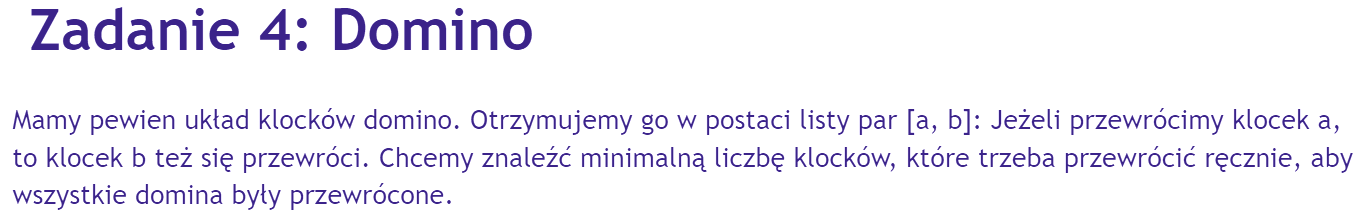

### Złożoność

###### Obliczeniowa:
$ O(V + E) $
###### Pamięciowa:
$ O(V + E) $ - bo tworzymy graf z odwróconymi krawędziami

### Implementacja

In [1]:
def directed_graph_list(E: 'array of edges', n: 'number of vertices'):
    G = [[] for _ in range(n)]
    for edge in E:
        G[edge[0]].append(edge[1])
    return G


def get_process_times(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    times = [0] * n
    visited = [False] * n
    time = 0
    
    def dfs(u):
        visited[u] = True
        for v in G[u]:
            if not visited[v]:
                dfs(v)
        nonlocal time
        time += 1
        times[u] = time
        
    for u in range(n):
        if not visited[u]:
            dfs(u)
            
    return times


def get_transposed_graph(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    
    for u in range(n):
        for v in G[u]:
            G2[v].append(u)
            
    return G2


def get_vertices_order(times):
    n = len(times)
    order = [-1] * n
    for i in range(n):
        order[n - times[i]] = i
    return order


def find_coherent_components(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    # Get processing time of each vertex
    times = get_process_times(G)
    # Create transposed graph
    G = get_transposed_graph(G)
    # Get order of vertices in which DFS will be started from such vertices
    order = get_vertices_order(times)
    # Create an array in which a result will be stored (each number will refer
    # to the other coherent component of a graph)
    result = [-1] * n  # This array will also be used to check if a vertex was visited
    num = 0
    
    def dfs(u):
        result[u] = num
        for v in G[u]:
            if result[v] < 0:
                dfs(v)
        
    # Start dfs from vertices of the highest processing time
    for i in range(n):
        u = order[i]
        if result[u] < 0:
            dfs(u)
            num += 1
            
    return result, num


def coherent_components_graph(G: 'directed graph represented using adjacency lists'):
    components, n2 = find_coherent_components(G)
    n = len(G)
    G2 = [[] for _ in range(n2)]
    
    for u in range(n):
        for v in G[u]:
            u2 = components[u]
            v2 = components[v]
            if v2 != u2:
                G2[u2].append(v2)
                
    return G2


def count_vertices_without_ingoing_edges(G: 'directed graph represented using adjacency lists'):
    count = n = len(G)
    has_ingoing_edge = [False] * n
    for u in range(n):
        for v in G[u]:
            if not has_ingoing_edge[v]:
                has_ingoing_edge[v] = True
                count -= 1
    return count


def count_dominoes_to_knock(E: 'array of dominoes pairs'):
    # Get a number of domino pieces
    n = 0
    for edge in E:
        n = max(n, edge[0], edge[1])
    n += 1
    # Create a DAG based on domino pieces
    G = directed_graph_list(E, n)
    # Create a graph of coherent components
    G2 = coherent_components_graph(G)
    # Count a number of vertices with no ingoing edges
    return count_vertices_without_ingoing_edges(G2)

###### Kilka testów

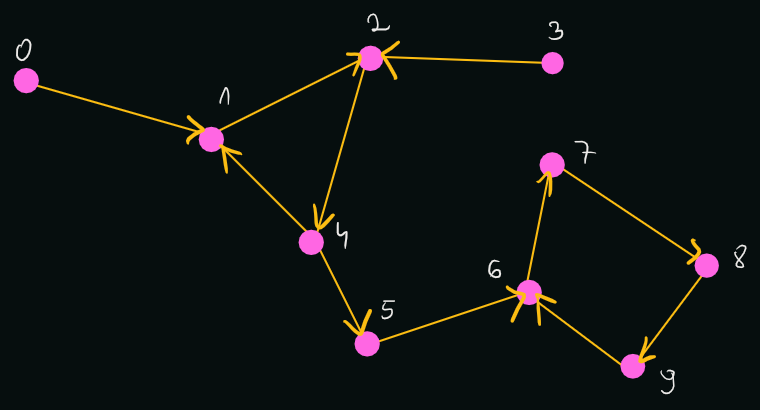

In [2]:
E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6)]

# G = directed_graph_list(E, max(e for edge in E for e in edge) + 1)
# print(*G, sep='\n')
# print(find_coherent_components(G))
# print(coherent_components_graph(G))
print(count_dominoes_to_knock(E))

2


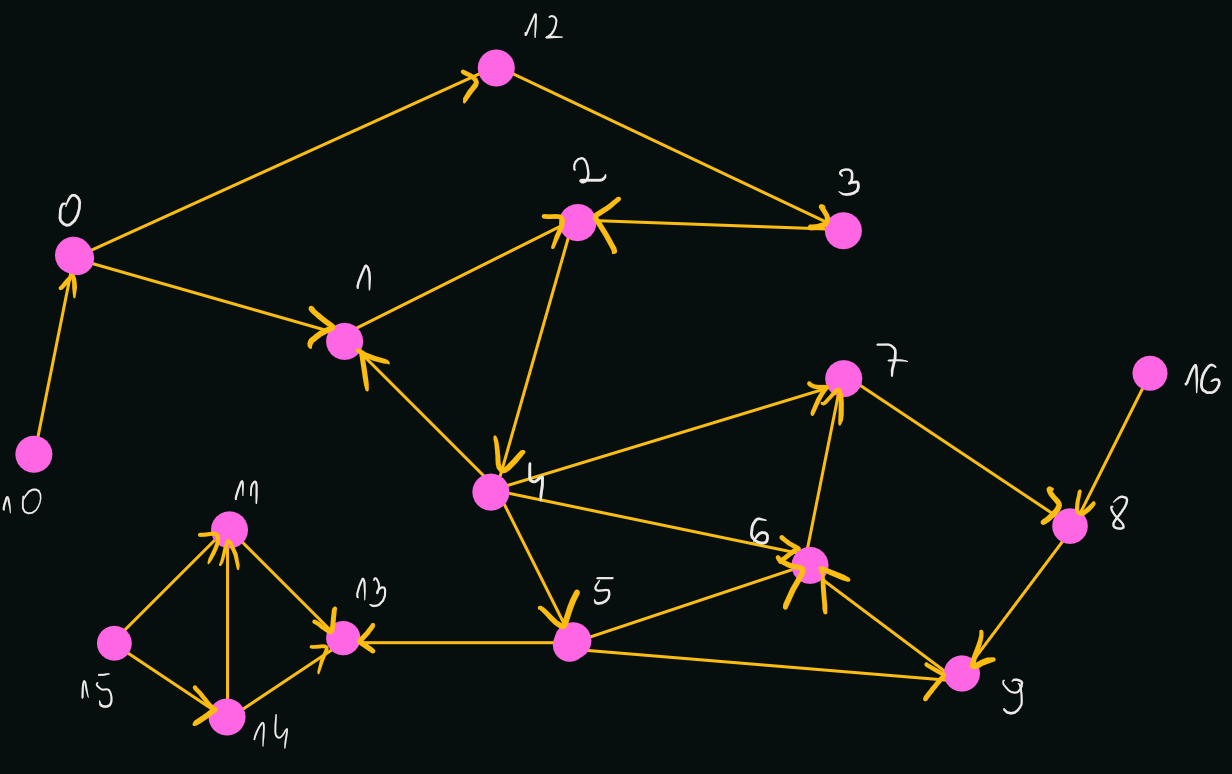

In [3]:
E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6),
     (4, 7), (4, 6), (5, 9), (10, 0), (15, 14), (15, 11), (15, 11), (11, 13), (14, 13), (5, 13),
     (16, 8), (0, 12), (12, 3)]

print(count_dominoes_to_knock(E))

3


### (Dodatkowo) Znajdowanie, które klocki należy przewrócić

W poniższej implementacji zamiast zliczania wierzchołków, które nie mają krawędzi wchodzących, zapisujemy indeksy tych wierzchołków (ale indeksy te muszą odpowiadać indeksom domino, jakie otrzymaliśmy na wejściu, więc musimy zapamiętywać reprezentantów silnie spójnych składowych. Przez reprezentanta rozumiem indeks dowolnego klocka domino, który znalazł się w danej silnie spójnej składowej, ponieważ jego przewrócenie gwarantuje nam, że przewrócone zostaną wszystkie klocki, które należą do jednej silnie spójnej składowej).
###### UWAGA:
W poniższej implementacji już nie tworzę nowego grafu z odwróconymi krawędziami, lecz transponuję graf <br>w miejscu (może być to wymagane, jeżeli mamy mocno ograniczoną złożoność pamięciową). Również nie tworzę nowego grafu spójnych składowych, lecz modyfikuję wcześniejszy graf w taki sposób, by stał się on grafem silnie spójnych składowych. Ponieważ korzystam z transpozycji grafu w miejscu, konieczna jest możlwość szybkiej modyfikacji struktruy, która trzyma sąsiadów (sposób postępowania przedstawiony niżej na ilustracji (<a href="#transpose">TUTAJ</a>)). <br>Z tego powodu, sąsiadów będę trzymał w strukturze deque (można zaimplementować własną listę odsyłaczową).

In [4]:
from collections import deque


def directed_graph_list(E: 'array of edges', n: 'number of vertices'):
    G = [deque() for _ in range(n)]
    for edge in E:
        G[edge[0]].append(edge[1])
    return G


def transpose_graph(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    # Store indices of the beginnings of new neighbours added to each vertex
    new_indices = [len(G[u]) for u in range(n)]
    
    # For each vertex remove its all old neighbours (vertices stored before the
    # first new added vertex) and for each of these removed neighbours append 
    # the current vertex to their new neighbours (this will be a reversed edge)
    for u in range(n):
        for _ in range(new_indices[u]):
            v = G[u].popleft()
            G[v].append(u)
        new_indices[u] = 0


def get_process_times(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    times = [0] * n
    visited = [False] * n
    time = 0
    
    def dfs(u):
        visited[u] = True
        for v in G[u]:
            if not visited[v]:
                dfs(v)
        nonlocal time
        time += 1
        times[u] = time
        
    for u in range(n):
        if not visited[u]:
            dfs(u)
            
    return times


def get_vertices_order(times):
    n = len(times)
    order = [-1] * n
    for i in range(n):
        order[n - times[i]] = i
    return order


def find_coherent_components(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    # Get processing time of each vertex
    times = get_process_times(G)
    # Transpose a graph (reverse all the edges)
    transpose_graph(G)
    # Get order of vertices in which DFS will be started from such vertices
    order = get_vertices_order(times)
    # Create an array in which a result will be stored (each number will refer
    # to the other coherent component of a graph)
    result = [-1] * n  # This array will also be used to check if a vertex was visited
    num = 0
    
    def dfs(u):
        result[u] = num
        for v in G[u]:
            if result[v] < 0:
                dfs(v)
        
    # Start dfs from vertices of the highest processing time
    for i in range(n):
        u = order[i]
        if result[u] < 0:
            dfs(u)
            num += 1
            
    # Don't transpose it again as we should normally do, because after transforming
    # to coherent components graph we will get the result faster when no transposition
    # is made
            
    return result, num


def map_to_coherent_components_graph(G: 'directed graph represented using adjacency lists',
                                     comp: 'array of components indices which vertices belong to',
                                     m: 'number of unique coherent components'):
    # This array will hold indices of components representatives which will
    # become new indices of a graph (all the vertices from the same coherent
    # component will be merged with this one)
    represent = [None] * m 
    n = len(G)
    
    for u in range(n):
        # If there is no representative of the current coherent component, store the current
        # vertex as its representative
        if represent[comp[u]] is None:
            represent[comp[u]] = u
        # Remove all the edges of the current vertex which connect it with all other
        # vertices in the coherent component
        for _ in range(len(G[u])):
            v = G[u].popleft()
            if comp[v] != comp[u]:
                G[represent[comp[u]]].append(comp[v])
    
    # Remove empty vertices and fix mapped vertices to these of coherent components
    mapped = [None] * m
    for i in range(m):
        mapped[i] = G[represent[i]]
    for i in range(m):
        G[i] = mapped[i]
        
    # Pop all the empty entries remaining
    for _ in range(n - m):
        G.pop()
        
    return represent

        
def get_dominoes_to_knock(E: 'array of dominoes pairs'):
    # Get a number of domino pieces
    n = 0
    for edge in E:
        n = max(n, edge[0], edge[1])
    n += 1
    # Create a DAG based on domino pieces
    G = directed_graph_list(E, n)
    # Map a graph to the graph of coherent components (which is transposed)
    components, count = find_coherent_components(G)
    represent = map_to_coherent_components_graph(G, components, count)
    # Find vertices with no outgoing edges (as a graph is transposed, now our
    # problem changed to a problem of finding vertices with no outgoing edges
    # which is much easier as we can immediately check a number of outgoing
    # edges of each vertex)
    n2 = len(G)
    result = []
    for u in range(n2):
        # If has no outgoing edges
        if not G[u]:
            result.append(represent[u])  # Append the original domino index
    return result

###### Kilka testów

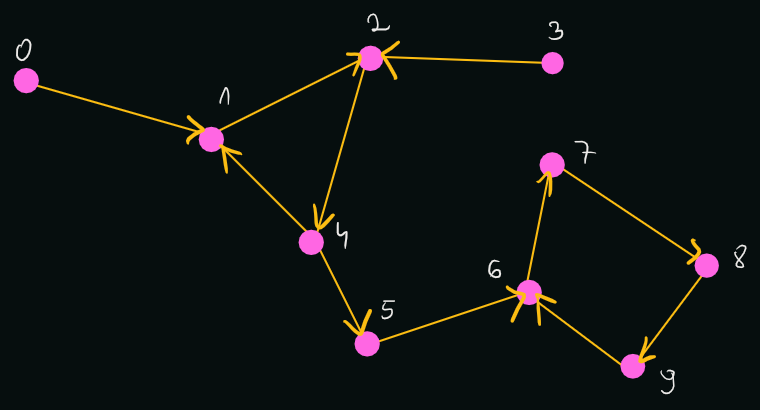

In [5]:
E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6)]

print(get_dominoes_to_knock(E))

[3, 0]


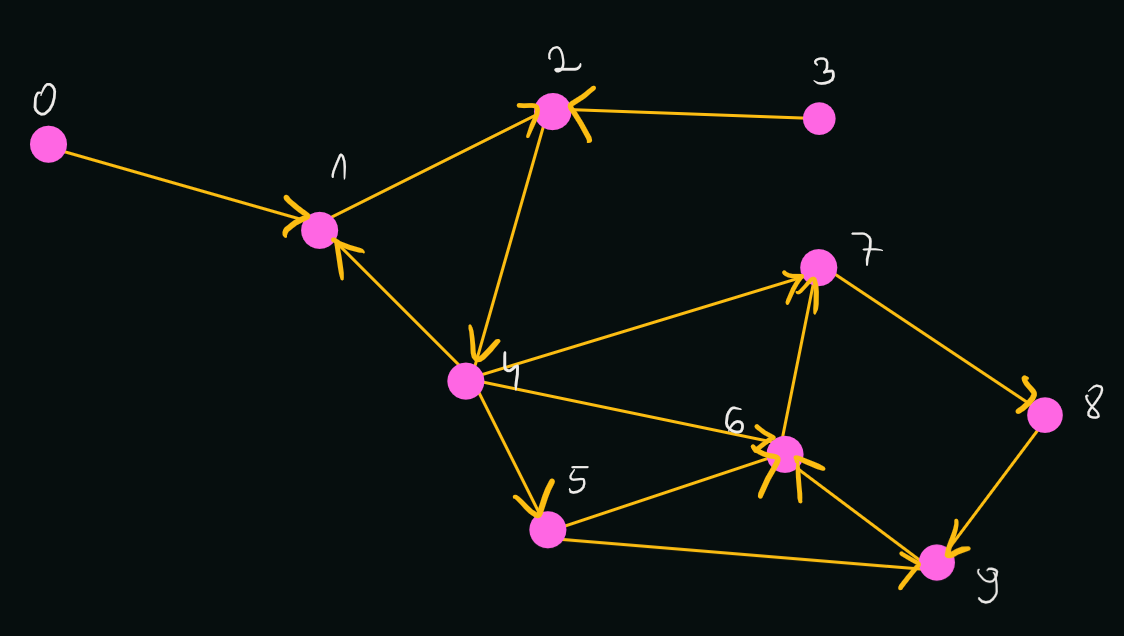

In [6]:
E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6),
     (4, 7), (4, 6), (5, 9)]

print(get_dominoes_to_knock(E))

[3, 0]


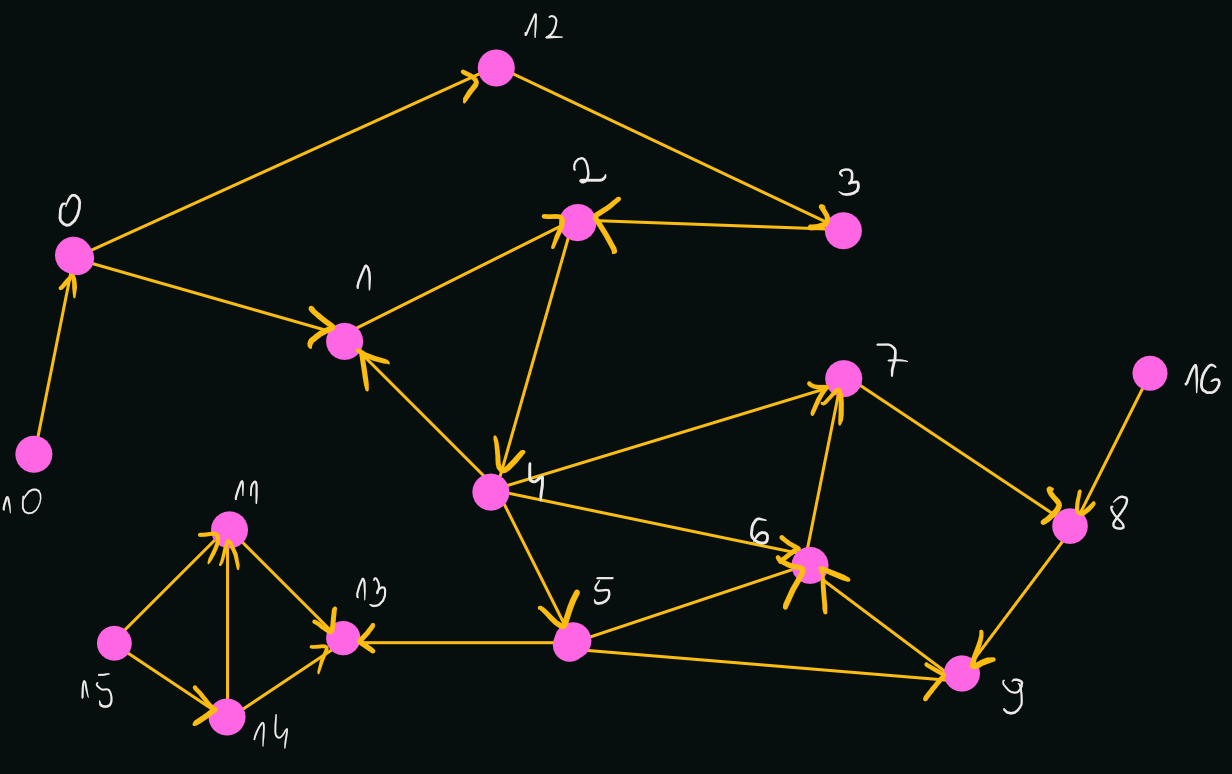

In [7]:
E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6),
     (4, 7), (4, 6), (5, 9), (10, 0), (15, 14), (15, 11), (15, 11), (11, 13), (14, 13), (5, 13),
     (16, 8), (0, 12), (12, 3)]

print(get_dominoes_to_knock(E))

[16, 15, 10]


##### Debug: <span id="transpose"></span>

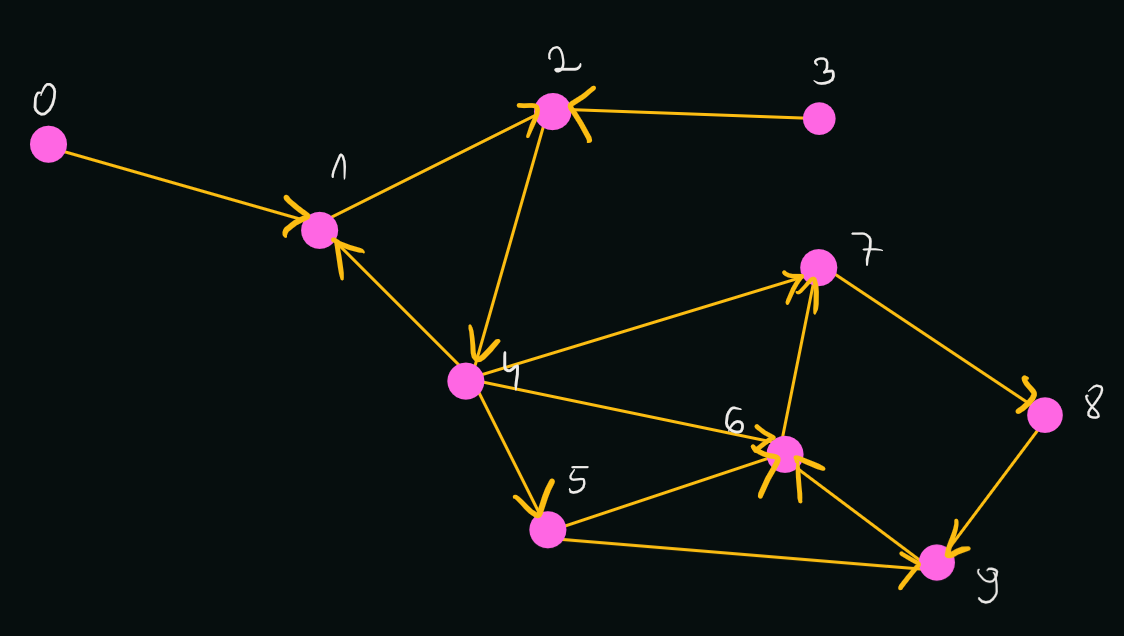

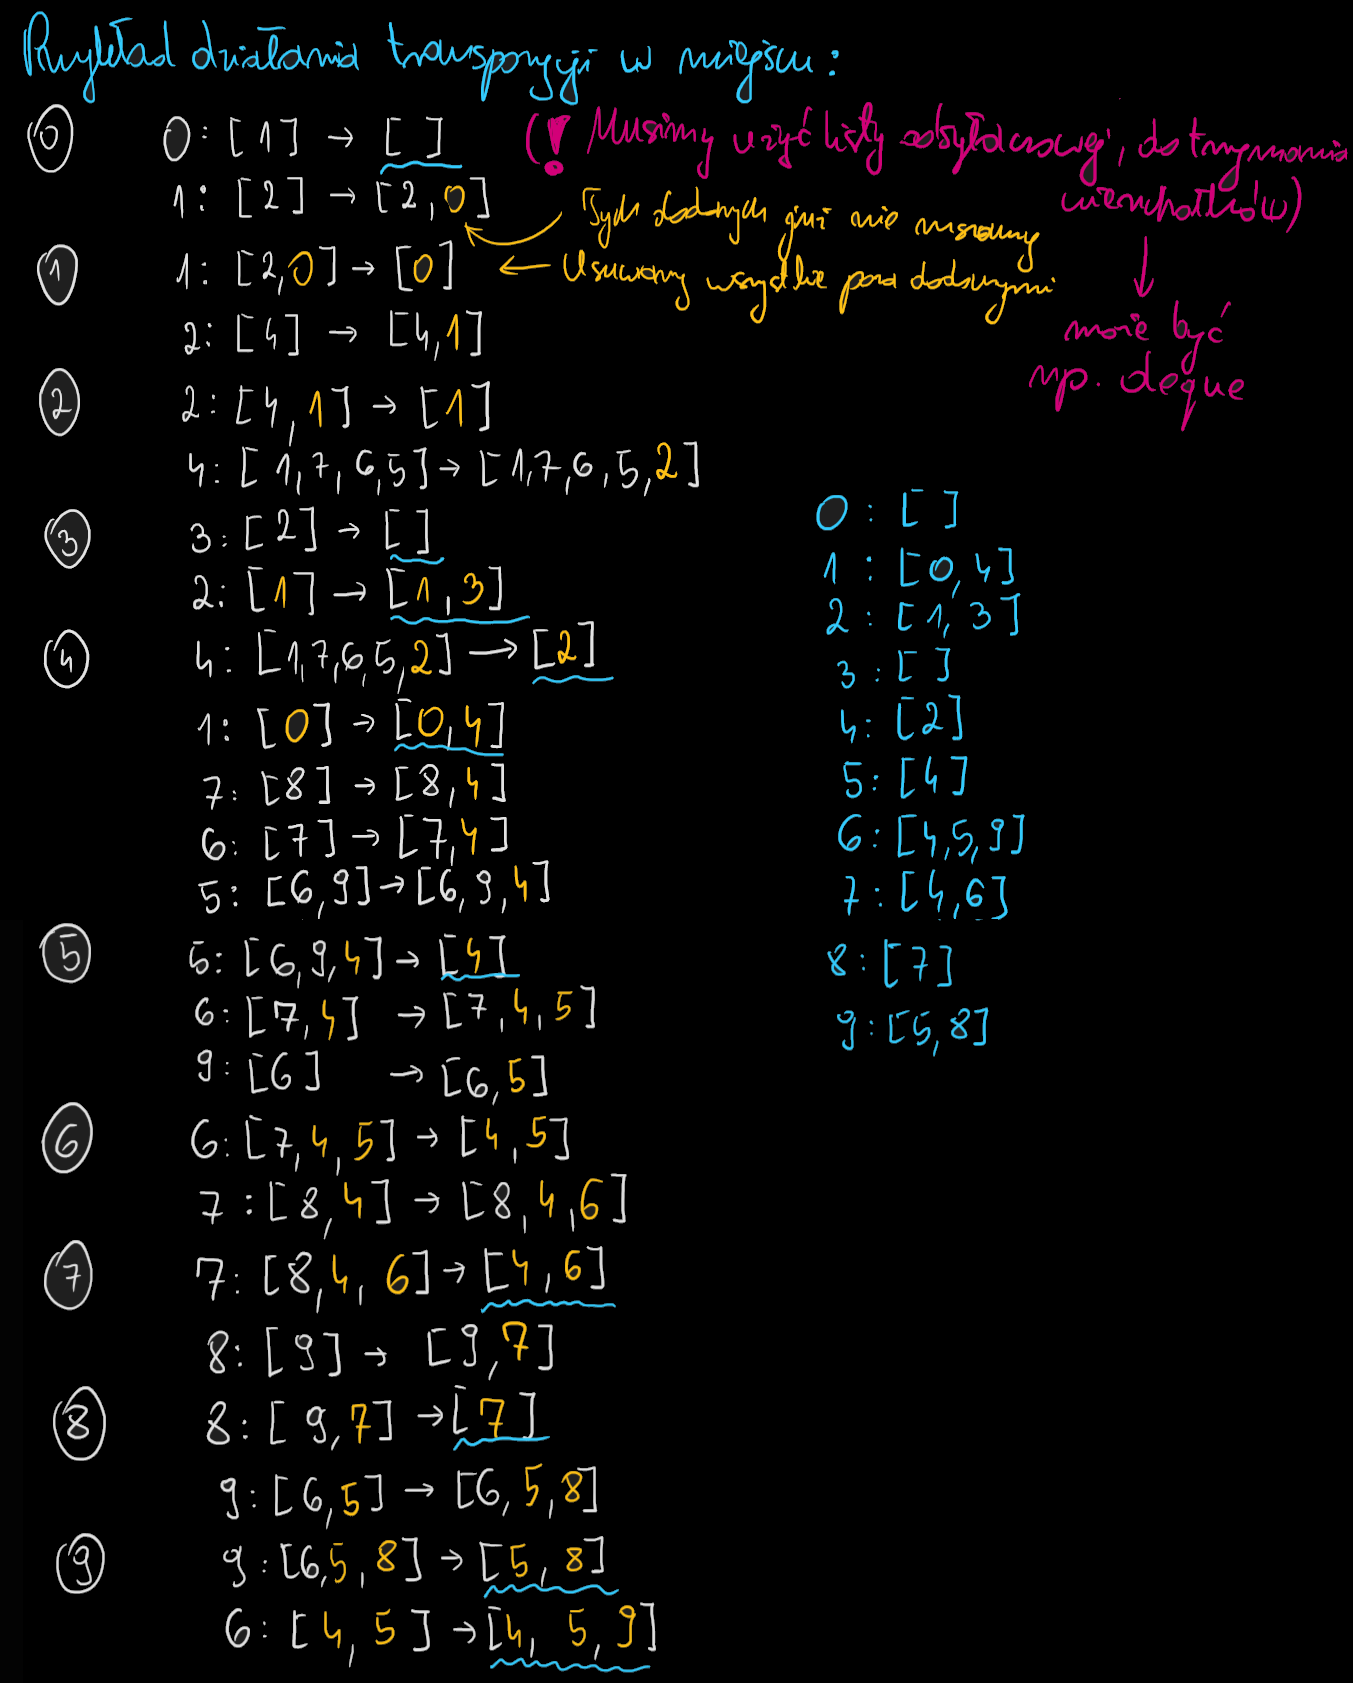

In [8]:
from collections import deque


def directed_graph_list(E: 'array of edges', n: 'number of vertices'):
    G = [deque() for _ in range(n)]
    for edge in E:
        G[edge[0]].append(edge[1])
    return G


def transpose_graph(G: 'directed graph represented using adjacency lists'):
    n = len(G)
    # Store indices of the beginnings of new neighbours added to each vertex
    new_indices = [len(G[u]) for u in range(n)]
    
    # For each vertex remove its all old neighbours (vertices stored before the
    # first new added vertex) and for each of these removed neighbours append 
    # the current vertex to their new neighbours (this will be a reversed edge)
    for u in range(n):
        for i in range(new_indices[u]):
            v = G[u].popleft()
            G[v].append(u)
        new_indices[u] = 0

In [9]:
import copy

E = [(0, 1), (1, 2), (3, 2), (2, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 6),
     (4, 7), (4, 6), (5, 9)]

G = directed_graph_list(E, max(e for edge in E for e in edge) + 1)
G_cp = copy.deepcopy(G)
print(*G, sep='\n')

deque([1])
deque([2])
deque([4])
deque([2])
deque([1, 5, 7, 6])
deque([6, 9])
deque([7])
deque([8])
deque([9])
deque([6])


In [10]:
transpose_graph(G)
print(*G, sep='\n')

deque([])
deque([0, 4])
deque([1, 3])
deque([])
deque([2])
deque([4])
deque([4, 5, 9])
deque([4, 6])
deque([7])
deque([5, 8])


In [11]:
# Click many times the run button of this cell to see how a graph is being transposed
transpose_graph(G)
print(*G, sep='\n')
# The order of neighbours may change so I use set to compare if there are the same neighbours
print('The same as original?:', all(set(neigh1) == set(neigh2) for neigh1, neigh2 in zip(G, G_cp)))

deque([1])
deque([2])
deque([4])
deque([2])
deque([1, 5, 6, 7])
deque([6, 9])
deque([7])
deque([8])
deque([9])
deque([6])
The same as original?: True
